# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
using Luxor
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 4
_DIM_A    = 1
Fmax      = 10.0 #7.5 #15.0 #25.0 #5.0 #10.0 #20.0
Fdiv      = 4.0 #8.0 # 4.0
_X_DOMAIN = [ -30.0 +30.0 ; # thetaDotDot
              -15.0 +15.0 ; # thetaDot
              -20.0 +20.0 ; # theta
              -10.0 +10.0 ] # xDot
_A_DOMAIN = [ -Fmax +Fmax ]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10;

nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state

include("env_cartpole.jl");

# Q-Learning Helpers

In [3]:
"""
Assemble <State,Action> into Q-state
"""
function get_Q( X, A )
    res = zeros( nQ );
    res[ 1:nX ] = X[:];
    if typeof( A ) == Float64
        res[ nX+1 ] = A;
    else
        res[ nX+1:nQ ] = A;
    end
    return res;
end


"""
Disassemble <State,Action> into Q-state
"""
function XA_from_Q( Q )
    return Q[ 1:nX ], Q[ nX+1:nQ ];
end

"""
Select the relvant variables from the state vector
"""
function select_X_vector( Xbig )
    return [ Xbig[1], Xbig[2], Xbig[3], Xbig[5] ]
end

"""
Normalize `theta` to shortest angle to zero
"""
function norm_turn( theta )
    thetaN = abs( theta % (2*pi) )
    if thetaN > pi
        thetaN = (2*pi) - thetaN
    end
    return thetaN
end


"""
Reward high speed at the bottom and low speed at the top
"""
function cartpole_reward( X )
    
    # 0. Set limits
    maxThetaDot =  10.0
    maxX        =   2.0
    # 1. Set weights
    thFactor    = 100.0
    thDotFactor =   8.0
    
    # 2. Unpack & Normalize state
    thetaDotN   = abs( X[2] ) # ----- Angular velocity
    thetaN      = X[3] # Angle
    xN          = abs( X[6] ) # ----- Fulcrum position
    # 3. Reward high speed at the bottom and low speed at the top
    R = thFactor*cos(thetaN) - thDotFactor*cos(thetaN)*(thetaDotN)
    
    
    if xN > maxX
        R -= xN
    end
    # if thetaDotN > maxThetaDot
    #     R -= thetaDotN
    # end
    return R
end


"""
Given a state `X`, determine the best action
"""
function optimal_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   = 0.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = cartpole_reward( Xp )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_exp( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    # println( testPts )
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy_exp( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Return number of seconds that penulum was within double-sided `angleMargin` of vertical
"""
function vertical_score_s( stateHistory, angleMargin, ts )
    angles = stateHistory[3,:]
    N      = length( angles )
    score  = 0.0
    # println( "vertical_score_s: Analize series of ", N, " timesteps." )
    for j = 1:N
        if abs( angles[j] ) <= angleMargin
            score += ts
        end
    end
    return score
end;

# Q-Function Hacks

In [4]:
"""
Blend two vectors by element
"""
function blend_alpha_of_A_into_B( alpha, A, B )
    return A*alpha + B*(1.0 - alpha)
end


"""
Exchange nonzero values
"""
function exchange_nonzeros( A, B )
    rtnA = zeros( size(A, 1) )    
    rtnB = zeros( size(B, 1) )
    N    = size(A, 1)
    for j = 1:N
        
        # Handle A
        if A[j] == 0.0
            rtnA[j] = B[j]
        else
            rtnA[j] = A[j]
        end
        
        # Handle B
        if B[j] == 0.0
            rtnB[j] = A[j]
        else
            rtnB[j] = B[j]
        end
    end
    
    return rtnA, rtnB
end;

# CartPole Environment Parameters

In [5]:
dur_s     = 40
ts        = 0.01

0.01

# Agent Data Structs

In [6]:
Fres     = Fmax/Fdiv
spaceDiv = 4.0 # 1.0 # 2.0 # 5.0 # 7.5  

### Construct grid of anchors ###
G    = regular_grid_pts_nD( _Q_DOMAIN, [ spaceDiv, spaceDiv, spaceDiv, spaceDiv, Fres ] );
nPts = size( G )[2]; # ------- Number of anchors
mDim = size( G )[1]; # ------- Dimensionality of anchors 
V    = zeros(Float64, nPts); # Values at anchors
VS   = zeros(Float64, nPts); # Scratch values
vsts = zeros(Int64, nPts); # - Set number of visits to zero
println( size( G ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( G            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( G[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( G             ); 
X_blTree = BallTree( G[1:_DIM_X,:] ); 

(5, 76032)


In [7]:
T       = Int64((1/ts)*dur_s)
N_0     = N_cart( 0.0, 0.0, pi/2.0 )
X_0     = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
states  = zeros( size( X_0, 1 ), T )
actions = zeros( T );
bestXs  = zeros( size( X_0, 1 ), T )
bestAs  = zeros( T );

In [8]:
vSwp = zeros(Float64, nPts); # Swap values
vBst = zeros(Float64, nPts); # Best values
vBAv = zeros(Float64, nPts); # Values for best average
vBlA = zeros(Float64, nPts); # Values for best average
vAll = zeros(Float64, nPts); # Absorbs all training

In [9]:
vB25 = zeros(Float64, nPts); # Best 25 : Train 75
vB50 = zeros(Float64, nPts); # Best 50 : Train 50
vB75 = zeros(Float64, nPts); # Best 75 : Train 25
vB90 = zeros(Float64, nPts); # Best 90 : Train 10
vB95 = zeros(Float64, nPts); # Best 95 : Train  5

# Agent Hyperparameters

In [10]:
##### Params #####
scale = 7.5; #1.650; # ----------- scale
vNN   =  4 #10 #4 #6 #3 # Value nearest neighbors
bNN   =  1; #1 # Blend nearest neighbors

@assert Fres < scale "!! `scale` SET TOO LOW !!"

alpha    = 0.15
gamma    = 0.99 
epsMin   = 0.05 # 0.05
epsMax   = 0.50 #0.50 #0.15 #0.50 # 0.3 # 0.75 # 1.00
episodes =  64 # 32 #64 #2048 #1024 #128 #512 #256 #20 # 160 # 40 # 80
epochs   =  64 #128 #64 # 32 #16
EXPrand  = 1.00 #0.25 #0.5 # 0.75
Alpha    = 0.875
aMargin  = (pi/180)*15.0;

# Training


Epoch 1, Best Score: -100.0, Best Average: -100.0
Training Iteration 4 score: 0.0, epsilon: 0.47890625000000003
Training Iteration 8 score: 0.0, epsilon: 0.4507812500000001
Training Iteration 12 score: 0.0, epsilon: 0.4226562500000001
Training Iteration 16 score: 0.0, epsilon: 0.39453125000000017
Training Iteration 20 score: 0.0, epsilon: 0.3664062500000002
Training Iteration 24 score: 0.0, epsilon: 0.33828125000000026
Training Iteration 28 score: 0.0, epsilon: 0.3101562500000003
Training Iteration 32 score: 0.0, epsilon: 0.28203125000000034
Training Iteration 36 score: 0.0, epsilon: 0.2539062500000004
Training Iteration 40 score: 0.0, epsilon: 0.22578125000000043
Training Iteration 44 score: 0.0, epsilon: 0.19765625000000048
Training Iteration 48 score: 0.0, epsilon: 0.16953125000000052
Training Iteration 52 score: 0.0, epsilon: 0.14140625000000057
Training Iteration 56 score: 0.0, epsilon: 0.11328125000000058
Training Iteration 60 score: 0.0, epsilon: 0.08515625000000057
Training It

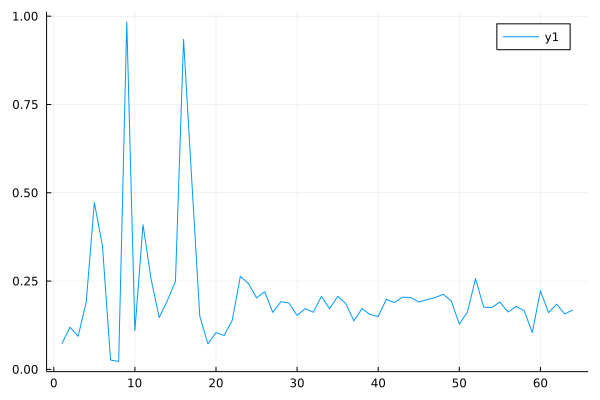

In [11]:
bgn       = time()
averages  = []
bestScore = -100.0;
bestAvg   = -100.0;

for m = 1:epochs
    
    println( "\nEpoch ", m, ", Best Score: ", bestScore, ", Best Average: ", bestAvg )
    
    epsilon = epsMax 
    deltaEp = (epsMax - epsMin)/episodes
    s_Prev  = 0.0
    s_Totl  = 0.0
    
    for l = 1:episodes
        X  = X_0

        for k = 1:T

            # 1. Choose action
            if rand() < epsilon
                if rand() < EXPrand 
                    A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                else
                    A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                end
            else

                A = learned_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                if A == 1000.0 # Indicates no values in this region
                    if rand() < EXPrand 
                        A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                    else
                        A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                    end
                end
            end

            # 2. Cache last state
            qLast = get_Q( select_X_vector( X ), A )

            # 3. Generate the next stae
            Xp = cartpole_dyn( X, A, ts )

            # 4. Collect reward R( s, a, s' )
            R_t = cartpole_reward( Xp )

            # 5. Get the optimal action at the next state
            a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fres ], ts )

            # 6. Compute the value at the next state

            V_tp1_opt = query_value_fuzzy( 
                Q_kdTree, G, V, 
                get_Q( 
                    select_X_vector( Xp ), 
                    a_tp1_opt 
                ); 
                k = vNN 
            )
            if isnan( V_tp1_opt )
                V_tp1_opt = 0.0
            end


            # 7. Blend the value back into nearest points

            idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, qLast; k = bNN )

            nNear      = size( idxs, 1 )
            for i = 1:nNear
                j    = idxs[i]
                if !isnan( wgts[i] ) 

                    # VS[j] = R_t + gamma * V_tp1_opt # Q-Learning
                    VS[j] = VS[j] + alpha*( R_t + V_tp1_opt - V[j] ) # Q(TD)-Learning
                    
                end
            end

            states[:,k] = Xp
            actions[k]  = A

            X = Xp
        end

        s_l    = vertical_score_s( states, aMargin, ts )
        s_Totl += s_l
    
        if s_l > bestScore
            bestScore = s_l
            bestXs    = copy( states  )
            bestAs    = copy( actions )
            vBst      = copy( V )
        end
        
        if l%4 == 0
            println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        end
        
        # Decay the exploration probability
        epsilon -= deltaEp

        # Swap Q-functions for Double Q-Learning
        vSwp = copy( VS   )
        VS   = copy( V    )
        V    = copy( vSwp )
        
    end
    
    s_Avg = s_Totl / episodes
    println( "Average Score: ", s_Avg )
    
    append!( averages, s_Avg )
    
    if (s_Avg > bestAvg) && true
        println( "BLEND" )
        bestAvg = s_Avg
        vBAv    = copy( V ) # Try a blend of both next
        vBlA    = blend_alpha_of_A_into_B( 0.50, VS, V )
    end
    
end

vTrn = copy( V )
println( "Saved a trained Q-table with size ", size( vTrn ), ", After ", (time()-bgn)/60.0, " minutes of training!" )

using Plots

plot( averages )

# Method 2 Performance, Longest Vertical Duration [s]
Each score is the best run out of an entire training period: 64 epochs of 64 episodes each, Q-function swap after every episode  
* Plain: 2.12
* Blended: 3.14, 33.15, 2.61, 3.45, 2.5 - Avg: 8.97
* TD: 28.24, 17.57, 34.31, 34.32, 33.65 - Avg: 29.62
* TD, Blended: 25.21, 30.70, 24.22, 33.53, 27.03 - Avg: 28.13  

Blending does not appear to improve Q(TD) top performance. You should still check if it raises average performance